## Important details of the first order formulation
This notebook here is to test the first order ODE solver

The main thing to worry about is the fact that we need to do some mode sorting in order to properly evaluate the eigenmodes for the $E$ and $H$ fields (so it matches with the 2nd order formulation, which automatically does 'mode sorting').

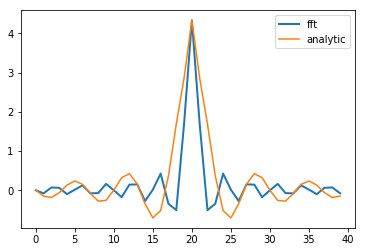

C:\Users\zhaon\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


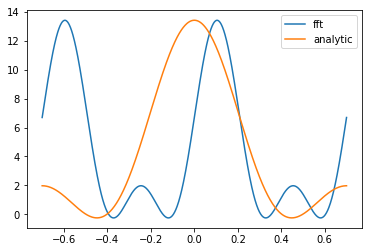

In [1]:
## same as the analytic case but with the fft
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cond
import cmath;
from scipy.fftpack import fft, fftfreq, fftshift, rfft
from scipy.fftpack import dst, idst
from scipy.linalg import expm
from scipy import linalg as LA

# Moharam et. al Formulation for stable and efficient implementation for RCWA
plt.close("all")
'''
1D TE implementation of PLANAR DIFFRACTiON...the easy case
only: sign convention is exp(-ikr) (is the positive propagating wave), so loss is +  not - 
source for fourier decomps is from the paper: Formulation for stable and efficient implementation of
the rigorous coupled-wave analysis of binary gratings by Moharam et. al
'''
np.set_printoptions(precision = 4)

def grating_fourier_harmonics(order, fill_factor, n_ridge, n_groove):
    """ function comes from analytic solution of a step function in a finite unit cell"""
    #n_ridge = index of refraction of ridge (should be dielectric)
    #n_ridge = index of refraction of groove (air)
    #n_ridge has fill_factor
    #n_groove has (1-fill_factor)
    # there is no lattice constant here, so it implicitly assumes that the lattice constant is 1...which is not good

    if(order == 0):
        return n_ridge**2*fill_factor + n_groove**2*(1-fill_factor);
    else:
        #should it be 1-fill_factor or fill_factor?, should be fill_factor
        return(n_ridge**2 - n_groove**2)*np.sin(np.pi*order*(fill_factor))/(np.pi*order);

def grating_fourier_array(num_ord, fill_factor, n_ridge, n_groove):
    """ what is a convolution in 1D """
    fourier_comps = list();
    for i in range(-num_ord, num_ord+1):
        fourier_comps.append(grating_fourier_harmonics(i, fill_factor, n_ridge, n_groove));
    return fourier_comps;

def fourier_reconstruction(x, period, num_ord, n_ridge, n_groove, fill_factor = 0.5):
    index = np.arange(-num_ord, num_ord+1);
    f = 0;
    for n in index:
        coef = grating_fourier_harmonics(n, fill_factor, n_ridge, n_groove);
        f+= coef*np.exp(cmath.sqrt(-1)*np.pi*n*x/period);
        #f+=coef*np.cos(np.pi*n*x/period)
    return f;

def fourier_reconstruction_general(x, period, num_ord, coefs):
    '''
    overloading odesn't work in python...fun fact, since it is dynamically typed (vs statically typed)
    :param x:
    :param period:
    :param num_ord:
    :param coefs:
    :return:
    '''
    index = np.arange(-num_ord, num_ord+1);
    f = 0; center = int(len(coefs)/2); #no offset
    for n in index:
        coef = coefs[center+n];
        f+= coef*np.exp(cmath.sqrt(-1)*2*np.pi*n*x/period);
    return f;

def grating_fft(eps_r):
    assert len(eps_r.shape) == 2
    assert eps_r.shape[1] == 1;
    #eps_r: discrete 1D grid of the epsilon profile of the structure
    fourier_comp = np.fft.fftshift(np.fft.fft(eps_r, axis = 0)/eps_r.shape[0]);
    #ortho norm in fft will do a 1/sqrt(n) scaling
    return np.squeeze(fourier_comp);

# plt.plot(x, np.real(fourier_reconstruction(x, period, 1000, 1,np.sqrt(12), fill_factor = 0.1)));
# plt.title('check that the analytic fourier series works')
# #'note that the lattice constant tells you the length of the ridge'
# plt.show()

L0 = 1e-6;
e0 = 8.854e-12;
mu0 = 4*np.pi*1e-8;
fill_factor = 0.3; # 50% of the unit cell is the ridge material


num_ord = 2; #INCREASING NUMBER OF ORDERS SEEMS TO CAUSE THIS THING TO FAIL, to many orders induce evanescence...particularly
               # when there is a small fill factor
PQ = 2*num_ord+1;
indices = np.arange(-num_ord, num_ord+1)

n_ridge = 3.48; #3.48;              # ridge
n_groove =  1;                # groove (unit-less)
lattice_constant = 0.7;  # SI units
# we need to be careful about what lattice constant means
# in the gaylord paper, lattice constant exactly means (0, L) is one unit cell


d = 0.46;               # thickness, SI units
Nx = 2*256;
eps_r = n_groove**2*np.ones((2*Nx, 1)); #put in a lot of points in eps_r
border = int(2*Nx*fill_factor);
eps_r[0:border] = n_ridge**2;
fft_fourier_array = grating_fft(eps_r);
x = np.linspace(-lattice_constant,lattice_constant,1000);
period = lattice_constant;
fft_reconstruct = fourier_reconstruction_general(x, period, num_ord, fft_fourier_array);

fourier_array_analytic = grating_fourier_array(Nx, fill_factor, n_ridge, n_groove);
analytic_reconstruct = fourier_reconstruction(x, period, num_ord, n_ridge, n_groove, fill_factor)


plt.figure();
plt.plot(np.real(fft_fourier_array[Nx-20:Nx+20]), linewidth=2)
plt.plot(np.real(fourier_array_analytic[Nx-20:Nx+20]));
plt.legend(('fft', 'analytic'))
plt.show()

plt.figure();
plt.plot(x,fft_reconstruct)
plt.plot(x,analytic_reconstruct);
plt.legend(['fft', 'analytic'])
plt.show()

## simulation parameters
theta = (0)*np.pi/180;


## construct permittivity harmonic components E
#fill factor = 0 is complete dielectric, 1 is air

##construct convolution matrix
E = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); E = E.astype('complex')
p0 = Nx; #int(Nx/2);
p_index = np.arange(-num_ord, num_ord + 1);
q_index = np.arange(-num_ord, num_ord + 1);
fourier_array = fft_fourier_array;#fourier_array_analytic;
detected_pffts = np.zeros_like(E);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        E[prow, pcol] = fourier_array[p0 + pfft];  # fill conv matrix from top left to top right

## IMPORTANT TO NOTE: the indices for everything beyond this points are indexed from -num_ord to num_ord+1








##  Calculating the Poynting Vector of a Sum of Plane Waves
Each plane wave has a contributing amplitude. Do we sum all the plane waves then calculate the Poynting vector or can we sum the Poynting vectors of the individual waves? The issue is that a product of a sum is not the same as the sum of products. Presently, I've tried both. It only appears to work in the simple case of 0 orders (or just plane waves).

Technically, each plane has has a different propagation in $k_z$ indexed by their Fourier index, which means we cna't deal with the components by themselves, we'd have to add in their phase. We could also just set $z=0$ to avoid this nasty problem.

Secret Sauce: Obviously with the Fourier order decomposition in $x$, some of the fourier $k_{zi}$ components may be evanescent. These components should have no contribution to the Poynting vector (especially in the far-field).

### some debugging notes
the long wavelength case should be error-free because there is little scattering into higher diffraction orders... but it appears to be the opposite in our test case below. Mathematically, however, we can see it in the fact that we have $m_i \lambda$ when we determine our kx_array, which means larger wavelengths have larger contributions at higher orders, which is a weird sounding statement.

In the 2nd order, stable formulation, we take eigenvalues with positive real parts and negative imaginary parts, so it would appear this is the sorting we would want to enforce. 

It is clear that solving the first order and second order eigenvalue problems lead to the same set of eigenvalues, but the choice selected by the second order problem seems weird (i.e., it isn't in order)

Empirically, it seems that sorting the larger block eigenvalues FAILS period.

In [80]:
## plot snippets
## plot verifies that all eigenvalues extracted by beigenvals matches with one in Q
#     plt.subplot(121)
#     for b in beigenvals:
#         plt.axhline(np.imag(b))
#     plt.plot(np.imag(np.diag(Q)),'.g-', markersize = 10)
#     plt.title(str((len(beigenvals), len(np.diag(Q)))))
#     plt.subplot(122)
#     for b in beigenvals:
#         plt.axhline(np.real(b))
#     plt.plot(np.real(np.diag(Q)),'.g-', markersize = 10)
#     plt.title('real')
#     plt.show()

## snippet to check maching square of eigenvals
#     for b in np.abs(np.square(beigenvals)):
# #         plt.axhline(b);

# #     plt.plot(sorted(np.abs(eigenvals)));
# #     plt.show();

wavelength: 0.5
conditioning of big block: 252.52236520327313
sorted beigenvals: [-3.0021e-01-1.8419e-16j -2.0660e-01+1.2113e-16j -2.2204e-15-3.2831e+00j
 -1.1188e-15+2.2336e+00j -8.8818e-16+3.2831e+00j -5.4745e-16-9.5783e-01j
 -4.6232e-16+9.5783e-01j -2.7387e-16-2.2336e+00j  2.0660e-01-1.4724e-16j
  3.0021e-01+2.1007e-17j]
extracted eigenvals: [-3.0021e-01-1.8419e-16j -2.0660e-01+1.2113e-16j -2.2204e-15-3.2831e+00j
 -1.1188e-15+2.2336e+00j -8.8818e-16+3.2831e+00j]
sorted eigenvals: [(1.1389564795321832e-17-3.2831379836827783j), (2.4005412831074446e-17+2.2336280760680496j), (1.3897163675822255e-16-0.9578271420377215j), (0.20660423116159407+1.9460240511139967e-16j), (0.30021283136614973-2.877443054598234e-16j)]


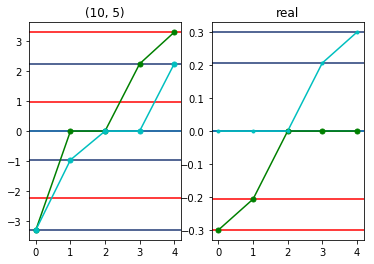

wavelength: 0.5947368421052631
conditioning of big block: 19.18724702470743
sorted beigenvals: [-8.9722e-01-1.0689e-16j -7.4128e-01+1.1750e-16j -4.3021e-15-3.2471e+00j
 -1.3323e-15+3.2471e+00j -1.3267e-15+2.1066e+00j -6.4274e-16-2.1066e+00j
 -1.5762e-16+8.9976e-01j  5.8014e-16-8.9976e-01j  7.4128e-01+2.4924e-16j
  8.9722e-01+3.4032e-16j]
extracted eigenvals: [-8.9722e-01-1.0689e-16j -7.4128e-01+1.1750e-16j -4.3021e-15-3.2471e+00j
 -1.3323e-15+3.2471e+00j -1.3267e-15+2.1066e+00j]
sorted eigenvals: [(1.0788172133925074e-17-0.8997589543455988j), (5.985806754136941e-17-3.2470680039762447j), (1.2323411354017693e-16-2.1065676601681425j), (0.7412847244948966-1.0793177790938997e-16j), (0.8972187572338552-1.5388351849393625e-16j)]


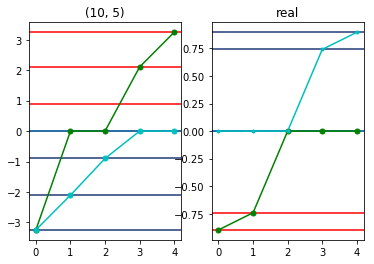

wavelength: 0.6894736842105262
conditioning of big block: 14.844330286448308
sorted beigenvals: [-1.2927e+00+3.8911e-17j -1.0933e+00+9.9849e-17j -5.3291e-15+3.2070e+00j
 -8.9109e-16-1.9601e+00j -2.7517e-16+1.9601e+00j -9.7145e-17-3.2070e+00j
 -9.3044e-17-8.3237e-01j  8.2781e-16+8.3237e-01j  1.0933e+00-5.4649e-16j
  1.2927e+00-4.7602e-16j]
extracted eigenvals: [-1.2927e+00+3.8911e-17j -1.0933e+00+9.9849e-17j -5.3291e-15+3.2070e+00j
 -8.9109e-16-1.9601e+00j -2.7517e-16+1.9601e+00j]
sorted eigenvals: [(1.0142674196232701e-17-1.9601003109602895j), (7.291348561516984e-17+3.206992505963046j), (2.0595200653138474e-16+0.8323723411974725j), (1.09330620290586+3.2283614393550915e-17j), (1.2927021451352274-7.850830419615112e-17j)]


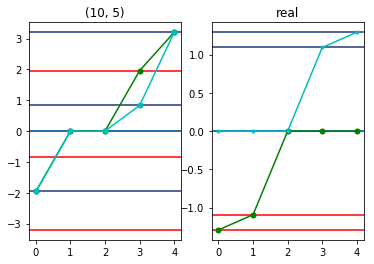

wavelength: 0.7842105263157895
conditioning of big block: 17.87768680640998
sorted beigenvals: [-1.6391e+00+1.9203e-16j -1.4150e+00-6.5765e-16j  0.0000e+00+3.1637e+00j
  3.3428e-16-7.4823e-01j  6.7336e-16+7.4823e-01j  9.1132e-16+1.7957e+00j
  1.3323e-15-3.1637e+00j  1.5756e-15-1.7957e+00j  1.4150e+00-4.2481e-17j
  1.6391e+00-9.7715e-16j]
extracted eigenvals: [-1.6391e+00+1.9203e-16j -1.4150e+00-6.5765e-16j  0.0000e+00+3.1637e+00j
  3.3428e-16-7.4823e-01j  6.7336e-16+7.4823e-01j]
sorted eigenvals: [(3.708849951181762e-17-0.7482334581300965j), (3.923899054818601e-17-3.163681731076764j), (7.577338766128716e-17+1.79566521401843j), (1.415045212040271+1.2064158669674376e-17j), (1.6391411649867573-7.591979088389357e-19j)]


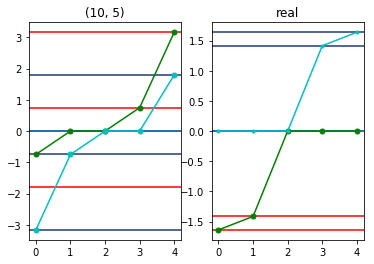

wavelength: 0.8789473684210526
conditioning of big block: 23.910775208120633
sorted beigenvals: [-1.9630e+00-1.8480e-15j -1.7288e+00-5.3900e-16j -8.7864e-16+3.1179e+00j
 -4.0621e-16+1.6134e+00j -2.8537e-16-1.6134e+00j -6.4431e-17-6.3762e-01j
  5.6551e-16+6.3762e-01j  2.2204e-15-3.1179e+00j  1.7288e+00+6.4060e-16j
  1.9630e+00-1.5378e-16j]
extracted eigenvals: [-1.9630e+00-1.8480e-15j -1.7288e+00-5.3900e-16j -8.7864e-16+3.1179e+00j
 -4.0621e-16+1.6134e+00j -2.8537e-16-1.6134e+00j]
sorted eigenvals: [(1.1822133370817854e-17-3.1178613269733715j), (6.184064832940294e-17-1.6134026313426473j), (1.486594426110581e-16+0.6376171164280358j), (1.7288106569881754-1.5960649764190852e-17j), (1.96301860468727-4.415971360424632e-17j)]


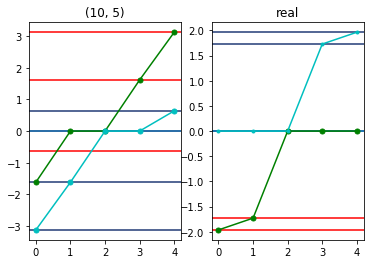

wavelength: 0.9736842105263157
conditioning of big block: 41.01672498366054
sorted beigenvals: [-2.2744e+00-1.9312e-15j -2.0408e+00+2.5098e-16j -2.9291e-16+1.4100e+00j
 -2.0545e-16-4.7939e-01j  0.0000e+00-3.0702e+00j  3.2727e-16+4.7939e-01j
  3.4808e-16-1.4100e+00j  9.7145e-16+3.0702e+00j  2.0408e+00-2.6833e-16j
  2.2744e+00+9.8845e-16j]
extracted eigenvals: [-2.2744e+00-1.9312e-15j -2.0408e+00+2.5098e-16j -2.9291e-16+1.4100e+00j
 -2.0545e-16-4.7939e-01j  0.0000e+00-3.0702e+00j]
sorted eigenvals: [(3.407151937392873e-18-3.070197451488491j), (7.33044480491394e-18+1.4100307774394647j), (1.9099932405103716e-16+0.4793865184934945j), (2.040796059003238-7.307300125311759e-17j), (2.274355853953827-4.861996797215514e-17j)]


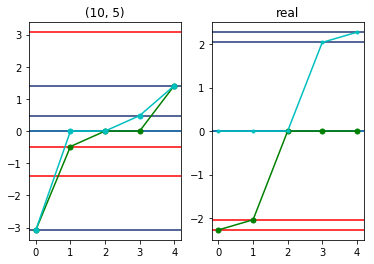

wavelength: 1.068421052631579
conditioning of big block: 342.02022490686716
sorted beigenvals: [-2.5779e+00+6.9507e-16j -2.3521e+00+1.0290e-15j -4.2061e-16+1.1754e+00j
 -2.6533e-16-1.6337e-01j -2.2041e-16-1.1754e+00j -1.6653e-16-3.0213e+00j
  3.6012e-16+1.6337e-01j  4.4409e-16+3.0213e+00j  2.3521e+00-6.6295e-16j
  2.5779e+00-9.2755e-16j]
extracted eigenvals: [-2.5779e+00+6.9507e-16j -2.3521e+00+1.0290e-15j -4.2061e-16+1.1754e+00j
 -2.6533e-16-1.6337e-01j -2.2041e-16-1.1754e+00j]
sorted eigenvals: [(3.961520641165062e-18+3.021296458982599j), (2.1251017466363734e-17+1.1753793789945874j), (2.599882007052892e-16-0.16336817125151715j), (2.3520813439420483+4.3877528306785556e-17j), (2.577944991742662+3.335493714723444e-17j)]


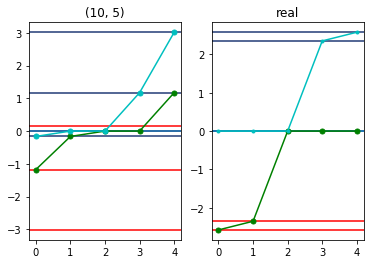

wavelength: 1.163157894736842
conditioning of big block: 42.92268615162663
sorted beigenvals: [-2.8764e+00-7.4385e-17j -2.6621e+00+1.5180e-16j -4.5359e-01+1.6589e-16j
 -4.4409e-16+2.9717e+00j  1.1102e-16-2.9717e+00j  2.6551e-16+8.8257e-01j
  2.9943e-16-8.8257e-01j  4.5359e-01-3.9783e-16j  2.6621e+00+2.4630e-16j
  2.8764e+00-2.5980e-17j]
extracted eigenvals: [-2.8764e+00-7.4385e-17j -2.6621e+00+1.5180e-16j -4.5359e-01+1.6589e-16j
 -4.4409e-16+2.9717e+00j  1.1102e-16-2.9717e+00j]
sorted eigenvals: [(9.782790371403292e-18-2.971713966515195j), (4.827907870120764e-16+0.8825688982937434j), (0.4535900914837506-2.1241672097789393e-16j), (2.6621364926768334+7.717591198459249e-18j), (2.8763678028293267-5.832240729066469e-18j)]


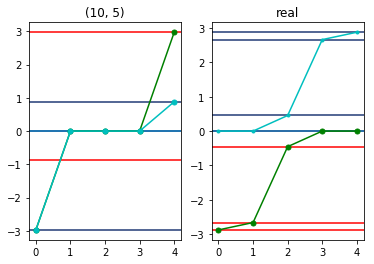

wavelength: 1.2578947368421052
conditioning of big block: 57.869660366891125
sorted beigenvals: [-3.1711e+00+4.9671e-16j -2.9702e+00+3.4533e-16j -6.8590e-01-3.5658e-17j
 -2.1103e-15-2.9220e+00j -1.4752e-15+2.9220e+00j -4.8428e-16-4.1686e-01j
  3.1111e-16+4.1686e-01j  6.8590e-01-4.3361e-17j  2.9702e+00-1.4326e-16j
  3.1711e+00+1.4326e-16j]
extracted eigenvals: [-3.1711e+00+4.9671e-16j -2.9702e+00+3.4533e-16j -6.8590e-01-3.5658e-17j
 -2.1103e-15-2.9220e+00j -1.4752e-15+2.9220e+00j]
sorted eigenvals: [(5.17042443043045e-18-2.9219667842408685j), (4.661034884508479e-16+0.41685749621024165j), (0.6858997111184391-2.2602585871687243e-16j), (2.970227361266898+8.596999907128543e-17j), (3.1711229626149984+7.979817026756084e-17j)]


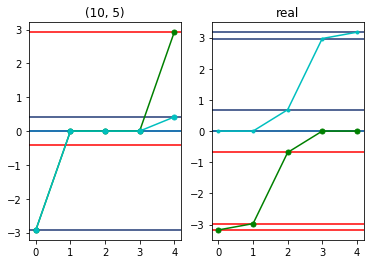

wavelength: 1.3526315789473684
conditioning of big block: 27.208998194358497
sorted beigenvals: [-3.4631e+00-5.1967e-17j -3.2759e+00-5.9048e-17j -8.7774e-01-2.8147e-17j
 -6.6392e-01-1.1455e-17j -6.2080e-16-2.8725e+00j -4.3081e-16+2.8725e+00j
  6.6392e-01+2.4864e-17j  8.7774e-01-2.7992e-17j  3.2759e+00-4.3995e-16j
  3.4631e+00-4.4823e-16j]
extracted eigenvals: [-3.4631e+00-5.1967e-17j -3.2759e+00-5.9048e-17j -8.7774e-01-2.8147e-17j
 -6.6392e-01-1.1455e-17j -6.2080e-16-2.8725e+00j]
sorted eigenvals: [(4.1159401406161784e-18-2.8725420127469414j), (0.6639150572219382+2.2722996956931883e-16j), (0.8777356339293179-1.2420061344674953e-16j), (3.2758662123086224-9.951757687862736e-18j), (3.463129997579631-1.2279373496679094e-17j)]


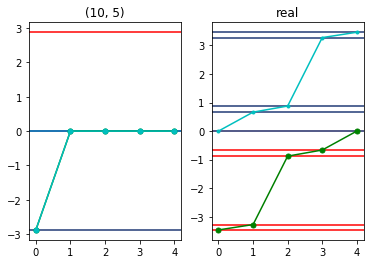

wavelength: 1.4473684210526314
conditioning of big block: 14.0848649986171
sorted beigenvals: [-3.7530e+00-6.6045e-16j -3.5789e+00+3.1754e-17j -1.0529e+00-7.5057e-17j
 -1.0347e+00+2.5254e-16j -1.4743e-15+2.8239e+00j -7.9214e-16-2.8239e+00j
  1.0347e+00-1.2145e-16j  1.0529e+00-1.0033e-16j  3.5789e+00+1.2145e-15j
  3.7530e+00+5.6184e-16j]
extracted eigenvals: [-3.7530e+00-6.6045e-16j -3.5789e+00+3.1754e-17j -1.0529e+00-7.5057e-17j
 -1.0347e+00+2.5254e-16j -1.4743e-15+2.8239e+00j]
sorted eigenvals: [(5.096848182862538e-18+2.8238997843725255j), (1.0347250356604485-2.623739740353737e-17j), (1.0528549373319604+5.531866762632374e-17j), (3.57885367988438-2.05721403471478e-17j), (3.752980815114448-2.2085018607549906e-17j)]


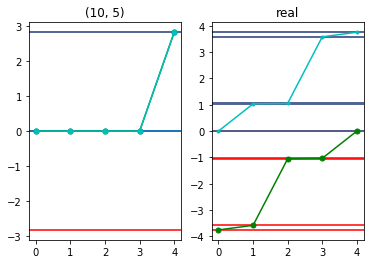

wavelength: 1.5421052631578946
conditioning of big block: 16.330281635792147
sorted beigenvals: [-4.0411e+00+1.2703e-15j -3.8792e+00-3.8001e-16j -1.3117e+00+3.5994e-16j
 -1.2196e+00+2.7846e-16j -2.4612e-15-2.7765e+00j -1.5004e-15+2.7765e+00j
  1.2196e+00+4.8652e-16j  1.3117e+00+2.7760e-16j  3.8792e+00-1.5942e-16j
  4.0411e+00-1.8402e-15j]
extracted eigenvals: [-4.0411e+00+1.2703e-15j -3.8792e+00-3.8001e-16j -1.3117e+00+3.5994e-16j
 -1.2196e+00+2.7846e-16j -2.4612e-15-2.7765e+00j]
sorted eigenvals: [(4.147989753612034e-17-2.7764687606474303j), (1.219584873827238-1.3231013630297884e-16j), (1.3117159441822686+1.5741021634641437e-16j), (3.8791986851835234+1.932450257005652e-17j), (4.041074317034042-4.649204954225588e-18j)]


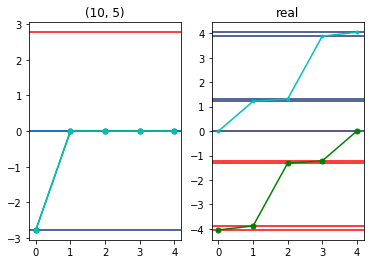

wavelength: 1.6368421052631579
conditioning of big block: 18.72891643306518
sorted beigenvals: [-4.3277e+00+7.7265e-16j -4.1770e+00-3.9690e-16j -1.5473e+00-3.7810e-16j
 -1.3818e+00-2.6106e-16j -7.1864e-16-2.7306e+00j  3.8941e-16+2.7306e+00j
  1.3818e+00+2.6775e-16j  1.5473e+00-8.0490e-17j  4.1770e+00-1.0825e-15j
  4.3277e+00-2.8242e-16j]
extracted eigenvals: [-4.3277e+00+7.7265e-16j -4.1770e+00-3.9690e-16j -1.5473e+00-3.7810e-16j
 -1.3818e+00-2.6106e-16j -7.1864e-16-2.7306e+00j]
sorted eigenvals: [(3.648138203311351e-17+2.7306358764433907j), (1.381825695442352-2.598266094338826e-16j), (1.5473471659440365-4.070490021909594e-17j), (4.177031742747165+8.385498122679177e-17j), (4.327691813549711+4.5671334440676804e-17j)]


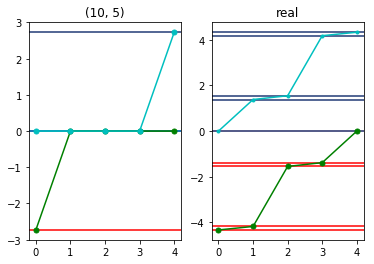

wavelength: 1.7315789473684209
conditioning of big block: 21.2801439612338
sorted beigenvals: [-4.6130e+00-9.4714e-18j -4.4725e+00+5.8860e-16j -1.7591e+00-1.7199e-17j
 -1.5416e+00+2.0762e-16j -7.5792e-16+2.6867e+00j  9.3857e-17-2.6867e+00j
  1.5416e+00-2.2497e-16j  1.7591e+00+9.6093e-17j  4.4725e+00+1.1080e-15j
  4.6130e+00+8.6837e-17j]
extracted eigenvals: [-4.6130e+00-9.4714e-18j -4.4725e+00+5.8860e-16j -1.7591e+00-1.7199e-17j
 -1.5416e+00+2.0762e-16j -7.5792e-16+2.6867e+00j]
sorted eigenvals: [(9.882572602632383e-17-2.686733436059824j), (1.5416354771063387-9.20524829867866e-17j), (1.7591203391620693-1.1164048055217539e-17j), (4.472542232036882-5.729466374871306e-17j), (4.613040641619555-5.1177086294012005e-17j)]


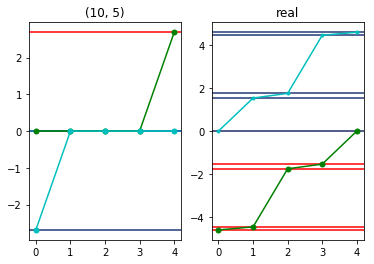

wavelength: 1.8263157894736841
conditioning of big block: 23.983351647286856
sorted beigenvals: [-4.8973e+00-2.9251e-16j -4.7659e+00+7.0828e-17j -1.9553e+00+1.0888e-16j
 -1.7001e+00+2.3242e-17j -2.0471e-15+2.6450e+00j -1.3930e-15-2.6450e+00j
  1.7001e+00-3.6245e-17j  1.9553e+00+1.1119e-16j  4.7659e+00-5.9824e-18j
  4.8973e+00-4.3888e-16j]
extracted eigenvals: [-4.8973e+00-2.9251e-16j -4.7659e+00+7.0828e-17j -1.9553e+00+1.0888e-16j
 -1.7001e+00+2.3242e-17j -2.0471e-15+2.6450e+00j]
sorted eigenvals: [(3.743282681377679e-17-2.645027215782735j), (1.700144201459957+6.125242330245572e-17j), (1.9553472225565744-9.613727379914245e-17j), (4.765939703352946+1.0990715902451226e-17j), (4.89728002541072+1.8140721281653814e-17j)]


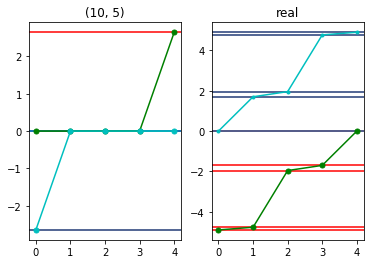

wavelength: 1.9210526315789471
conditioning of big block: 26.837961018880854
sorted beigenvals: [-5.1805e+00+9.9406e-16j -5.0574e+00+1.8477e-15j -2.1407e+00+1.0581e-16j
 -1.8580e+00+1.1994e-16j -1.5890e-15-2.6057e+00j -8.9799e-16+2.6057e+00j
  1.8580e+00-2.4434e-16j  2.1407e+00-2.3944e-16j  5.0574e+00-1.7404e-16j
  5.1805e+00+4.4070e-16j]
extracted eigenvals: [-5.1805e+00+9.9406e-16j -5.0574e+00+1.8477e-15j -2.1407e+00+1.0581e-16j
 -1.8580e+00+1.1994e-16j -1.5890e-15-2.6057e+00j]
sorted eigenvals: [(2.186073367453222e-17+2.6057086819189528j), (1.857961250220984+8.671389386636393e-17j), (2.140685163874244+1.677593297987946e-16j), (5.057432288848441+9.428655952108833e-17j), (5.18053675007531+8.719143243696313e-17j)]


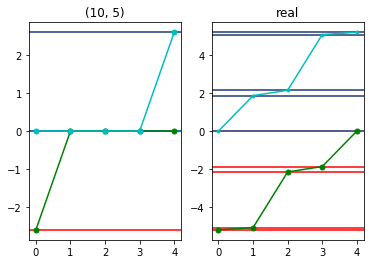

wavelength: 2.0157894736842104
conditioning of big block: 29.84343893759348
sorted beigenvals: [-5.4629e+00+3.5076e-16j -5.3472e+00+6.0353e-16j -2.3180e+00-3.3727e-16j
 -2.0154e+00+2.3081e-16j -4.0947e-16+2.5689e+00j  1.8915e-16-2.5689e+00j
  2.0154e+00-1.7286e-17j  2.3180e+00-4.1312e-16j  5.3472e+00-1.1331e-16j
  5.4629e+00+4.9086e-17j]
extracted eigenvals: [-5.4629e+00+3.5076e-16j -5.3472e+00+6.0353e-16j -2.3180e+00-3.3727e-16j
 -2.0154e+00+2.3081e-16j -4.0947e-16+2.5689e+00j]
sorted eigenvals: [(1.2510828194308068e-16-2.5688930885910257j), (2.0153885588563925-5.036699355392549e-17j), (2.3180148041981408+8.266222602299329e-18j), (5.347215788016465+5.300690470331748e-17j), (5.462914875558055+2.9641985350936366e-17j)]


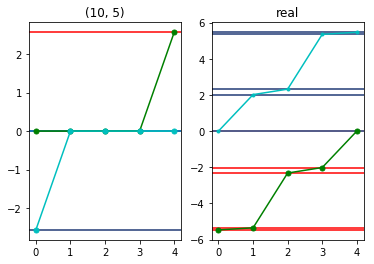

wavelength: 2.110526315789474
conditioning of big block: 32.99930214734672
sorted beigenvals: [-5.7445e+00+5.4592e-16j -5.6355e+00+1.9122e-16j -2.4892e+00+1.7444e-16j
 -2.1725e+00+8.4479e-17j -4.5052e-16-2.5346e+00j  4.7384e-16+2.5346e+00j
  2.1725e+00-1.2294e-16j  2.4892e+00+7.7660e-17j  5.6355e+00-1.4779e-15j
  5.7445e+00-1.0351e-15j]
extracted eigenvals: [-5.7445e+00+5.4592e-16j -5.6355e+00+1.9122e-16j -2.4892e+00+1.7444e-16j
 -2.1725e+00+8.4479e-17j -4.5052e-16-2.5346e+00j]
sorted eigenvals: [(7.691141600564065e-17-2.5346236098565673j), (2.172545199538471+2.21752988302625e-17j), (2.4892405784969434-2.353698039232124e-16j), (5.635468953516513-2.6995660792333643e-17j), (5.74450190593986-3.441160351924683e-17j)]


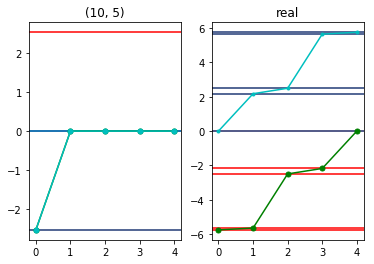

wavelength: 2.205263157894737
conditioning of big block: 36.30511759709409
sorted beigenvals: [-6.0254e+00-1.4627e-16j -5.9224e+00+3.1710e-16j -2.6557e+00-1.6516e-16j
 -2.3294e+00+1.0198e-16j -1.6103e-15-2.5029e+00j -8.1627e-16+2.5029e+00j
  2.3294e+00+2.2464e-16j  2.6557e+00+1.2149e-16j  5.9224e+00-6.9251e-16j
  6.0254e+00-3.6693e-16j]
extracted eigenvals: [-6.0254e+00-1.4627e-16j -5.9224e+00+3.1710e-16j -2.6557e+00-1.6516e-16j
 -2.3294e+00+1.0198e-16j -1.6103e-15-2.5029e+00j]
sorted eigenvals: [(2.4751655911417e-16-2.5028803317802004j), (2.3294451382387105-7.609282329086378e-17j), (2.65568406639148+5.733625852746689e-17j), (5.9223521905913845-1.330539741633346e-16j), (6.025372818099645-1.3307723343321127e-16j)]


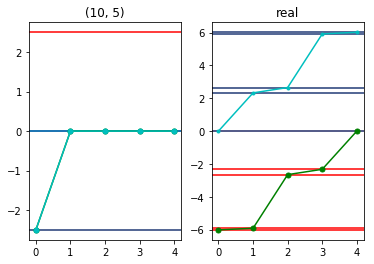

wavelength: 2.3
conditioning of big block: 39.76050026111445
sorted beigenvals: [-6.3056e+00+2.9222e-16j -6.2080e+00-1.9586e-17j -2.8183e+00-1.1467e-16j
 -2.4860e+00-1.6354e-17j -1.5275e-15-2.4736e+00j -1.0359e-15+2.4736e+00j
  2.4860e+00-2.3740e-16j  2.8183e+00-3.3662e-16j  6.2080e+00-1.8239e-15j
  6.3056e+00-1.0953e-15j]
extracted eigenvals: [-6.3056e+00+2.9222e-16j -6.2080e+00-1.9586e-17j -2.8183e+00-1.1467e-16j
 -2.4860e+00-1.6354e-17j -1.5275e-15-2.4736e+00j]
sorted eigenvals: [(1.4467550920602413e-16+2.473592212537164j), (2.4860469608544404-2.9947467903064876e-16j), (2.8182971209463745-1.695381868342947e-17j), (6.208008029373931-9.477442240863683e-18j), (6.3055927763466-2.961732077427532e-17j)]


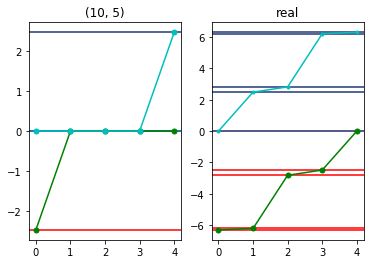

In [180]:
## alternate construction of 1D convolution matrix
spectra = list();
spectra_T = list();
I = np.identity(2 * num_ord + 1)
PQ = 2*num_ord+1;
zeros = np.zeros((PQ, PQ))
# E is now the convolution of fourier amplitudes
wavelength_scan = np.linspace(0.5,2.3,20)

for wvlen in wavelength_scan:
    j = cmath.sqrt(-1);
    lam0 = wvlen;     k0 = 2 * np.pi / lam0; #free space wavelength in SI units
    print('wavelength: ' + str(wvlen));
    ## =====================STRUCTURE======================##

    ## Region I: reflected region (half space)
    n1 = 1;#cmath.sqrt(-1)*1e-12; #apparently small complex perturbations are bad in Region 1, these shouldn't be necessary

    ## Region 2; transmitted region
    n2 = 1;

    #from the kx_components given the indices and wvln
    kx_array = k0*(n1*np.sin(theta) + indices*(lam0 / lattice_constant)); #0 is one of them, k0*lam0 = 2*pi
    k_xi = kx_array;
    ## IMPLEMENT SCALING: these are the fourier orders of the x-direction decomposition.
    KX = np.diag(kx_array/k0);
    KX2 = np.diag(np.power((k_xi/k0),2)); #singular since we have a n=0, m= 0 order and incidence is normal
    #print(KX2)
    KZ2 = ((n1)**2 - np.diag(KX2)).astype('complex');
    KZ = np.sqrt(KZ2)
#     print('KZ2: '+str(KZ2)+': imag Kz: '+str(KZ))
#     KZ_mask = np.imag(KZ)<1e-2;
#     KZ_mask = np.expand_dims(KZ_mask, axis = 1)
#     print(KZ_mask.shape)
    
    ## construct matrix of Gamma^2 ('constant' term in ODE):
    A = KX2 - E; #conditioning of this matrix is not bad, A SHOULD BE SYMMETRIC
    #sum of a symmetric matrix and a diagonal matrix should be symmetric;
    AO = np.block([[zeros, I],[A, zeros]])
    beigenvals, bigW = LA.eig(AO);
    print('conditioning of big block: '+str(np.linalg.cond(AO)))
    ## SORTING IS REQUIRED
    #sorting procedure is to order by smallest imaginary part to largest imaginary part
    # We actually have to calculate poynting vector (the modes are Ey, Hx) and Sz = -Ey*Hx
    # since we are dealing with a normalized H, we need to divide by 1/j;
    Ey_modes = bigW[0:PQ, :];
    Hx_modes = bigW[PQ:, :]
    

    EyAmp = np.sum(Ey_modes, axis = 0); #amplitude
    HxAmp = np.sum(Hx_modes, axis = 0);
    #EyAmp = np.sum(Ey_modes*KZ_mask, axis = 0); #amplitude
    #HxAmp = np.sum(Hx_modes*KZ_mask, axis = 0);
    
    ## right now it works for a uniform slab, any orders...which means it 
    Sz = (1/j)*EyAmp*(HxAmp);
#     print(Sz.shape)
    sorted_indices_poynting = np.argsort(Sz)
    sorted_indices = np.argsort(np.real(beigenvals))
    #print(Sz[sorted_indices])
    
    sorted_eigenmodes = bigW[:,sorted_indices ];
    #print(sorted_eigenmodes)
    #adding real and imaginary parts seems to work...
    sorted_eigenvals = beigenvals[sorted_indices]
    Wp = sorted_eigenmodes[0:PQ:,0:PQ]
    eigenvals_wp = (sorted_eigenvals[0:PQ]);
    print('sorted beigenvals: '+str(sorted_eigenvals))
    print('extracted eigenvals: '+str(eigenvals_wp))
#     Wp = sorted_eigenmodes[PQ:,0:PQ]
#     eigenvals_wp = (sorted_eigenvals[PQ:]);
    #print(eigenvals_wp.shape)
    #plt.plot(np.imag(sorted_eigenvals));
    #plt.show()
    ##
    # when we calculate eigenvals, how do we know the eigenvals correspond to each particular fourier order?
    eigenvals, W = LA.eig(A); #A should be symmetric or hermitian
    print('sorted eigenvals: '+str(sorted(np.sqrt(eigenvals))))

#     plt.subplot(121);
#     plt.imshow(np.abs(W));
#     plt.subplot(122);
#     plt.imshow(np.abs(bigW));
#     plt.show()
    
    W = Wp; 
    #V = sorted_eigenmodes[0:PQ, :]
    #we should be gauranteed that all eigenvals are REAL
    eigenvals = eigenvals.astype('complex');
    
    Qn = np.diag(np.sqrt(eigenvals)); #Q should only be positive square root of eigenvals
    #real parts match, but the imaginaries don't
    Q = np.diag(eigenvals_wp);
    #plt.plot(sorted(np.abs(beigenvals)),'.-');

    plt.subplot(121)
    for b in beigenvals:
        plt.axhline(np.imag(b), color='r')
    for b in np.sqrt(eigenvals):
        plt.axhline(np.imag(b))

    plt.plot(sorted(np.imag(np.diag(Q))),'.g-', markersize = 10)
    plt.plot(sorted(np.imag(np.diag(Qn))), '.c-', markersize = 10)
    plt.title(str((len(beigenvals), len(np.diag(Q)))))
    
    plt.subplot(122)
    
    for b in beigenvals:
        plt.axhline(np.real(b), color = 'r')
    for b in np.sqrt(eigenvals):
        plt.axhline(np.real(b))
        
    plt.plot(sorted(np.real(np.diag(Q))),'.g-', markersize = 10)
    plt.title('real')

    plt.plot(sorted(np.real(np.diag(Qn))), '.c-')
    plt.show()


    V = W@Q; #H modes

    X = np.diag(np.exp(-k0*np.diag(Q)*d)); #this is poorly conditioned because exponentiation
    ## pointwise exponentiation vs exponentiating a matrix

    ## observation: almost everything beyond this point is worse conditioned
    k_I = k0**2*(n1**2 - (k_xi/k0)**2);                 #k_z in reflected region k_I,zi
    k_II = k0**2*(n2**2 - (k_xi/k0)**2);   #k_z in transmitted region
    k_I = k_I.astype('complex'); k_I = np.sqrt(k_I);
    k_II = k_II.astype('complex'); k_II = np.sqrt(k_II);
    Y_I = np.diag(k_I/k0);
    Y_II = np.diag(k_II/k0);


    delta_i0 = np.zeros((len(kx_array),1));
    delta_i0[num_ord] = 1;
    n_delta_i0 = delta_i0*j*n1*np.cos(theta); #this is a VECTOR

    ## design auxiliary variables: SEE derivation in notebooks: RCWA_note.ipynb
    # we want to design the computation to avoid operating with X, particularly with inverses
    # since X is the worst conditioned thing

    Wi = np.linalg.inv(W);
    Vi = np.linalg.inv(V);
    Oi = 0.5*np.block([[Wi, Vi],[Wi, -Vi]])
    f = I;
    g = j*Y_II; #all matrices
    fg = np.concatenate((f,g),axis = 0)
    #ab = np.matmul(np.linalg.inv(O),fg);
    # ab = np.matmul(Oi, fg);
    # a = ab[0:PQ,:];
    # b = ab[PQ:,:];

    a = 0.5*(Wi+j*Vi@Y_II);
    b = 0.5*(Wi-j*Vi@Y_II);
    fbiX = np.matmul(np.linalg.inv(b),X)

    #altTerm = (a@X@X@b); #not well conditioned and I-altTermis is also poorly conditioned.
    #print(np.linalg.cond(I-np.linalg.inv(altTerm)))
    #print(np.linalg.cond(X@b)); #not well conditioned.

    term = X@a@fbiX; # THIS IS SHITTILY CONDITIONED
    # print((np.linalg.cond(X), np.linalg.cond(term)))
    # print(np.linalg.cond(I+term)); #but this is EXTREMELY WELL CONDITIONED.
    f = np.matmul(W, I+term);
    g = np.matmul(V,-I+term);
    T = np.linalg.inv(j*np.matmul(Y_I,f)+g);
    T = np.matmul(T,(np.matmul(j*Y_I,delta_i0)+n_delta_i0));
    R = np.matmul(f,T)-delta_i0;
    T = np.matmul(fbiX, T)

    ## calculate diffraction efficiencies
    #I would expect this number to be real...
    DE_ri = R*np.conj(R)*np.real(np.expand_dims(k_I,1))/(k0*n1*np.cos(theta));
    DE_ti = T*np.conj(T)*np.real(np.expand_dims(k_II,1))/(k0*n1*np.cos(theta));
    #print(np.sum(DE_ri))

    #print(np.sum(DE_ri))
    spectra.append(np.sum(DE_ri)); #spectra_T.append(T);
    spectra_T.append(np.sum(DE_ti))




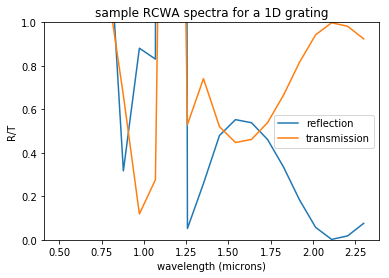

In [181]:

plt.figure();
plt.plot(wavelength_scan, np.abs(spectra));
plt.plot(wavelength_scan, np.abs(spectra_T))
plt.xlabel('wavelength (microns)')
plt.ylabel('R/T')
plt.title('sample RCWA spectra for a 1D grating')
plt.legend(['reflection', 'transmission'])
# plt.axhline(((3.48-1)/(3.48+1))**2,xmin=0, xmax = max(wavelength_scan))
# plt.axhline(((3.48-1)/(3.48+1)),xmin=0, xmax = max(wavelength_scan), color='r')
plt.ylim([0,1])
plt.show()

In [174]:
## comparison to the 2nd order, stable formulation
# also the first real test of the function